In [14]:
from dataclasses import dataclass, field
from darts.datasets.dataset_loaders import DatasetLoader
from typing import Optional
from pathlib import Path
import pickle

from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline

from darts.datasets import (
    ElectricityDataset,
    AirPassengersDataset,
    EnergyDataset,
    ExchangeRateDataset,
    ILINetDataset,
    TrafficDataset,
    UberTLCDataset,
    WeatherDataset,
    ETTm1Dataset,
    ETTm2Dataset,
    DatasetLoaderCSV
)

from dataclasses import dataclass
from typing import Callable, List, Optional, Union
@dataclass
class DatasetLoaderMetadata:
    # name of the dataset file, including extension
    name: str
    # uri of the dataset, expects a publicly available file
    uri: str
    # md5 hash of the file to be downloaded
    hash: str
    # used to parse the dataset file
    header_time: Optional[str]
    # used to convert the string date to pd.Datetime
    # https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    format_time: Optional[str] = None
    # used to indicate the freq when we already know it
    freq: Optional[str] = None
    # a custom function handling non-csv based datasets
    pre_process_zipped_csv_fn: Optional[Callable] = None
    # a custom function handling csv based datasets
    pre_process_csv_fn: Optional[Callable] = None
    # multivariate
    multivariate: Optional[bool] = None

class ElectricityConsumptionZurichDataset(DatasetLoaderCSV):
    """
    Electricity Consumption of households & SMEs (low voltage) and businesses & services (medium voltage) in the
    city of Zurich [1]_, with values recorded every 15 minutes.

    The electricity consumption is combined with weather measurements recorded by three different
    stations in the city of Zurich with a hourly frequency [2]_. The missing time stamps are filled with NaN.
    The original weather data is recorded every hour. Before adding the features to the electricity consumption,
    the data is resampled to 15 minutes frequency, and missing values are interpolated.

    To simplify the dataset, the measurements from the Zch_Schimmelstrasse and Zch_Rosengartenstrasse weather
    stations are discarded to keep only the data recorded in the Zch_Stampfenbachstrasse station.

    Both dataset sources are updated continuously, but this dataset only retrains values between 2015-01-01 and
    2022-08-31.
    The time index was converted from CET time zone to UTC.

    Components Descriptions:

    * Value_NE5 : Households & SMEs electricity consumption (low voltage, grid level 7) in kWh
    * Value_NE7 : Business and services electricity consumption (medium voltage, grid level 5) in kWh
    * Hr [%Hr] : Relative humidity
    * RainDur [min] : Duration of precipitation (divided by 4 for conversion from hourly to quarter-hourly records)
    * T [°C] : Temperature
    * WD [°] : Wind direction
    * WVv [m/s] : Wind vector speed
    * p [hPa] : Air pressure
    * WVs [m/s] : Wind scalar speed
    * StrGlo [W/m2] : Global solar irradiation

    Note: before 2018, the scalar speeds were calculated from the 30 minutes vector data.

    References
    ----------
    .. [1] https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich
    .. [2] https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte
    """

    def __init__(self):
        def pre_process_dataset(dataset_path):
            """Restrict the time axis and add the weather data"""
            df = pd.read_csv(dataset_path, index_col=0)
            # convert time index
            df.index = pd.DatetimeIndex(pd.to_datetime(df.index, utc=True)).tz_localize(
                None
            )
            # extract pre-determined period
            df = df.loc[
                (pd.Timestamp("2015-01-01") <= df.index)
                & (df.index <= pd.Timestamp("2022-08-31"))
            ]
            # download and preprocess the weather information
            df_weather = self._download_weather_data()
            # add weather data as additional features
            df = pd.concat([df, df_weather], axis=1)
            # interpolate weather data
            df = df.interpolate()
            # raining duration is given in minutes -> we divide by 4 from hourly to quarter-hourly records
            df["RainDur [min]"] = df["RainDur [min]"] / 4

            # round Electricity cols to 4 decimals, other columns to 2 decimals
            cols_precise = ["Value_NE5", "Value_NE7"]
            df = df.round(
                decimals={col: (4 if col in cols_precise else 2) for col in df.columns}
            )

            # export the dataset
            df.index.name = "Timestamp"
            df.to_csv(self._get_path_dataset())

        # hash value for dataset with weather data
        super().__init__(
            metadata=DatasetLoaderMetadata(
                "zurich_electricity_consumption.csv",
                uri=(
                    "https://data.stadt-zuerich.ch/dataset/"
                    "ewz_stromabgabe_netzebenen_stadt_zuerich/"
                    "download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
                ),
                hash="a019125b7f9c1afeacb0ae60ce7455ef",
                header_time="Timestamp",
                freq="15min",
                pre_process_csv_fn=pre_process_dataset,
            )
        )

    @staticmethod
    def _download_weather_data():
        """Concatenate the yearly csv files into a single dataframe and reshape it"""
        # download the csv from the url
        base_url = "https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte/download/"
        filenames = [f"ugz_ogd_meteo_h1_{year}.csv" for year in range(2015, 2023)]
        df = pd.concat([pd.read_csv(base_url + fname) for fname in filenames])
        # retain only one weather station
        df = df.loc[df["Standort"] == "Zch_Stampfenbachstrasse"]
        # pivot the df to get all measurements as columns
        df["param_name"] = df["Parameter"] + " [" + df["Einheit"] + "]"
        df = df.pivot(index="Datum", columns="param_name", values="Wert")
        # convert time index to from CET to UTC and extract the required time range
        df.index = pd.DatetimeIndex(pd.to_datetime(df.index, utc=True)).tz_localize(
            None
        )
        df = df.loc[
            (pd.Timestamp("2015-01-01") <= df.index)
            & (df.index <= pd.Timestamp("2022-08-31"))
        ]
        return df

@dataclass
class Dataset:
    source: DatasetLoader
    split: list
    loader_params: dict = field(default_factory=dict)
    preprocessing: Optional[list] = None
    encoders: dict = field(default_factory=dict)

def get_scaler():
    return Scaler()

def get_missing_filler():
    return MissingValuesFiller()

def get_scaler_missing():
    return Pipeline([MissingValuesFiller(), Scaler()])

dataset_map = {
    'electricity': Dataset(
        source=ElectricityDataset,
        split=[],
        loader_params={'multivariate': True},
        encoders= {
            'cyclic': {'past': ['month', 'dayofyear', 'dayofweek', 'hour']},
            'datetime_attribute': {'past': ['year', 'month']},
            # 'transformer': get_scaler(),
        }
    ),
    'exchange': Dataset(
        source=ExchangeRateDataset,
        split=[],
        loader_params={'multivariate': True},
        encoders= {
            'cyclic': {'past': ['month', 'dayofyear', 'dayofweek', 'hour']},
            'datetime_attribute': {'past': ['year', 'month']},
            # 'transformer': get_scaler(),
        }
    ),
    'ili': Dataset(
        source=ILINetDataset,
        split=[],
        loader_params={'multivariate': True},
        encoders= {
            'cyclic': {'past': ['month', 'dayofyear', 'dayofweek', 'hour']},
            'datetime_attribute': {'past': ['year', 'month']},
            # 'transformer': get_scaler(),
        }
    ),
    'traffic': Dataset(
        source=TrafficDataset,
        split=[],
        loader_params={'multivariate': True},
        encoders= {
            'cyclic': {'past': ['month', 'dayofyear', 'dayofweek', 'hour']},
            'datetime_attribute': {'past': ['year', 'month']},
            # 'transformer': get_scaler(),
        }
    ),
    'uber': Dataset(
        source=UberTLCDataset,
        split=[],
        loader_params={'multivariate': True},
        encoders= {
            'cyclic': {'past': ['month', 'dayofyear', 'dayofweek', 'hour']},
            'datetime_attribute': {'past': ['year', 'month']},
            # 'transformer': get_scaler(),
        }
    ),
    'weather': Dataset(
        source=WeatherDataset,
        split=[],
        loader_params={'multivariate': True},
        encoders= {
            'cyclic': {'past': ['month', 'dayofyear', 'dayofweek', 'hour']},
            'datetime_attribute': {'past': ['year', 'month']},
            # 'transformer': get_scaler(),
        }
    ),
    'ettm1': Dataset(
        source=ETTm1Dataset,
        split=[],
        encoders= {
            'cyclic': {'past': ['month', 'dayofyear', 'dayofweek', 'hour']},
            'datetime_attribute': {'past': ['year', 'month']},
            # 'transformer': get_scaler(),
        }
    ),
    'ettm2': Dataset(
        source=ETTm2Dataset,
        split=[],
        encoders= {
            'cyclic': {'past': ['month', 'dayofyear', 'dayofweek', 'hour']},
            'datetime_attribute': {'past': ['year', 'month']},
            # 'transformer': get_scaler(),
        }
    ),
    'airpassenger': Dataset(
        source=AirPassengersDataset,
        split=[],
        encoders= {
            'cyclic': {'past': ['month']},
            'datetime_attribute': {'past': ['year']},
            # 'transformer': get_scaler(),
        }
    ),
    # 'energy': Dataset(
    #     source=EnergyDataset,
    #     split=[],
    #     encoders= {
    #         'cyclic': {'past': ['month', 'dayofyear', 'dayofweek', 'hour']},
    #         'datetime_attribute': {'past': ['year', 'month']},
    #         # 'transformer': get_scaler(),
    #     }
    # ),
}


def get_data(dataset: str, cache_path):
    data_meta = dataset_map[dataset]

    cache_path = Path(cache_path) / f"{dataset}.pkl"
    
    if cache_path.exists():  # Data already exists in the cache.
        with open(cache_path, "rb") as f:
            data = pickle.load(f)
    else:  # Data needs to be downloaded/generated.
        data = data_meta.source(**data_meta.loader_params).load()

        # if data_meta.loader_params.get('multivariate', False) and not isinstance(data, list):
        if not isinstance(data, list):
            data = [data[component] for component in data.components]

        if isinstance(data, list):
            for i, d in enumerate(data):
                if np.any(np.isnan(d.values())):
                    filler = MissingValuesFiller()
                    data[i] = filler.transform(d)

        else:
           if np.any(np.isnan(data.values())):
               filler = MissingValuesFiller()
               data = filler.transform(data)
        
        # Saving data to cache.
        cache_path.parent.mkdir(parents=True, exist_ok=True)
        print(cache_path)
        with open(cache_path, "wb") as f:
            pickle.dump(data, f)

    if not isinstance(data, list):
        data = [data]

    mins, maxs = [], []
    for i, d in enumerate(data):
        m = d.min(axis=0).values().item()
        M = d.max(axis=0).values().item()
        mins.append(m)
        maxs.append(M)

        data[i] = (d - m) / (M - m)
        
    return data, data_meta.encoders, (mins, maxs)

In [2]:
from darts.datasets.dataset_loaders import DatasetLoader

In [15]:
from data.load import get_data, split_timeseries

data, split, encoders, m = get_data('electricity', '/lfs/turing3/0/kaif/GitHub/ts/data/cache')

# import numpy as np
# for k in dataset_map.keys():
#     data, encoders = get_data(k, '/lfs/turing3/0/kaif/GitHub/ts/data/cache')
#     if not isinstance(data, list):
#         data = [data]

#     for d in data:
#         if np.any(np.isnan(d.values())):
#             print(k)
#             break

<Axes: xlabel='Unnamed: 0'>

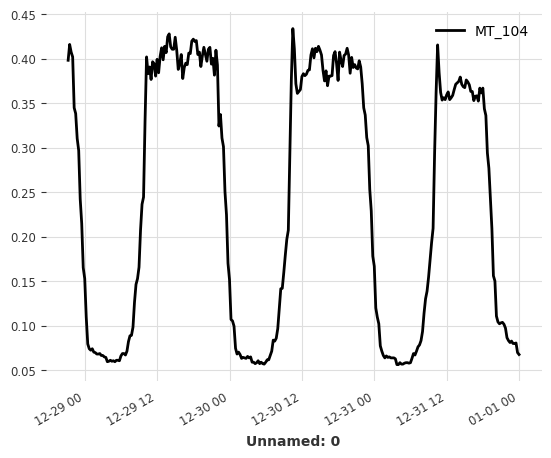

In [603]:
data[103][-300:].plot()

In [305]:
ts_energy = ElectricityConsumptionZurichDataset().load()

DatasetLoadingException: Expected hash for /lfs/turing3/0/kaif/.darts/datasets/zurich_electricity_consumption.csv: a019125b7f9c1afeacb0ae60ce7455ef, got: ff0f21dce99c6c4e7c22dd83c52fee63

In [290]:
split = [0.8, 0.99, 0.995]
data_split = split_timeseries(data, split)
if len(data_split) == 4:
    _, train, valid, test = data_split
elif len(data_split) == 3:
    train, valid, test = data_split
elif len(data_split) == 2:
    train, test = data_split
    valid = None
else:
    raise ValueError(f"Expected 2 or 3 splits for data, but found {len(data_split)}.")


In [289]:
valid[0]

<TimeSeries (DataArray) (Date Time: 264, component: 1, sample: 1)>
array([[[1.70569080e-02]],

       [[1.72119708e-02]],

       [[1.96929757e-02]],

       [[1.96929757e-02]],

       [[2.18638549e-02]],

       [[2.26391689e-02]],

       [[2.35695457e-02]],

       [[2.15537293e-02]],

       [[2.06233525e-02]],

       [[2.09334781e-02]],

...

       [[2.66552954e-01]],

       [[2.66397891e-01]],

       [[2.65622577e-01]],

       [[2.66708017e-01]],

       [[2.67483331e-01]],

       [[2.67018142e-01]],

       [[2.67173205e-01]],

       [[2.67793456e-01]],

       [[2.68103582e-01]],

       [[2.69499147e-01]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 2020-12-28T08:10:00 ... 2020-12-30T...
  * component  (component) object 'p (mbar)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [6]:
import numpy as np
np.any(np.isnan(data[0].values()))

False

In [212]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing.encoders import SequentialEncoder, PastDatetimeAttributeEncoder

add_encoders = {
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['year']},
    'transformer': Scaler(),
}

# encoder = SequentialEncoder(add_encoders,
#                             input_chunk_length=24, 
#                             output_chunk_length=12,
#                             lags_past_covariates=None,
#                             lags_future_covariates=None,
#                             takes_past_covariates=False,
#                             takes_future_covariates=True
#                            )
from darts.dataprocessing import Pipeline

encoder = PastDatetimeAttributeEncoder(
    input_chunk_length=24,
    output_chunk_length=12,
    attribute='month',
)

# scaler = Scaler()

# pipeline = Pipeline([encoder, scaler])

# data_aug = pipeline.fit_transform(data)
# data_aug = (data[0] / 400).add_datetime_attribute("month", cyclic=True)
# data_aug = data_aug.add_datetime_attribute("dayofweek")
# data_aug = data_aug.add_holidays("US")

# # encoder.encode_train(data)[1][:50].plot()
# past_covariates_train[0][:10].plot()

<Axes: xlabel='Unnamed: 0'>

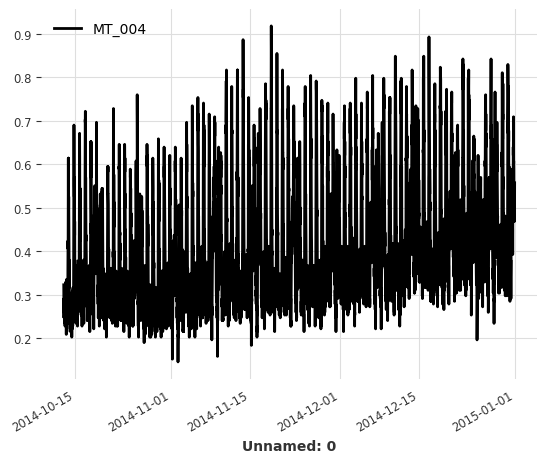

In [18]:
NR_DAYS = 80
DAY_DURATION = 24 * 4  # 15 minutes frequency

data[3][-NR_DAYS*DAY_DURATION:].plot()

<Axes: xlabel='time'>

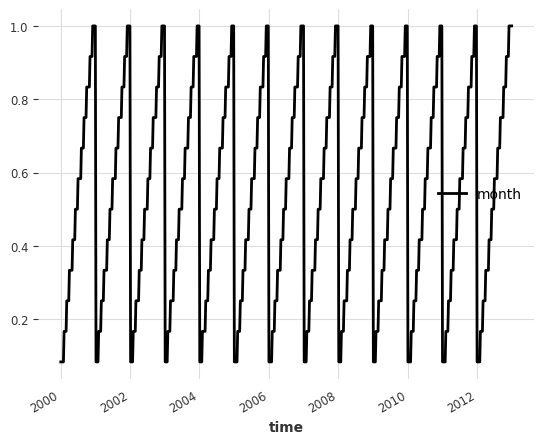

In [130]:
(datetime_attribute_timeseries(pd.date_range('2000-01-01', '2012-12-31', freq='W'), attribute='month') / 12).plot()

In [336]:
??hmms.CtHMM

Docstring:      <no docstring>
Init docstring:
Initialize the CtHMM by given parameters.
Q : (n,n) ndarray
    jump-rates matrix for (n) hidden states
    may be sparse (contain zeros) to spare some computation
B : (n,m) ndarray
    probability matrix of (m) observation symbols being emitted by (n) hidden state
Pi : (n) ndarray
    vector of initial probabilities
File:           ~/miniforge3/envs/ts/lib/python3.9/site-packages/hmms/cthmm.cpython-39-x86_64-linux-gnu.so
Type:           type
Subclasses:     

In [17]:
def gen_timeseries(source):
    time_steps = len(source)
    
    tr = 1 - np.random.rand() / 10
    # A is the matrix of transition probabilities from state [row] to state [column].
    A = np.array([[tr,1 - tr],[1 - tr,tr]])
    # B is the matrix of probabilities that the state [row] will emmit output variable [column].
    B = np.array([[0.9,0.1],[0.1, 0.9]])
    # Pi is the vector of initial state probabilities.   
    Pi = np.array( [0.8,0.2] )
    
    # Create DtHMM by given parameters.
    chmm = hmms.DtHMM(A,B,Pi)
    
    # Sample a sequence of states and corresponding emission values (our time series)
    states, series = chmm.generate(time_steps)
    
    # Convert series to Pandas Series for plotting
    t_index = pd.date_range(start='1/1/2000', periods=time_steps)
    t_series = pd.Series(series, index=t_index)

    # Define the mapping distributions for the new series
    state_distributions = {0: [0,0.3], 1: [3,0.3]}  # Mapping from state to distribution (mean, sd)
    
    # Generate the new series
    new_series = source.values().flatten() + np.array([np.random.normal(*state_distributions[state]) for state in states])
    
    # Convert to Pandas Series for plotting
    # new_t_series = pd.Series(new_series, index=source.time_index)# + np.sin(range(len(t_index)))
    
    series = TimeSeries.from_times_and_values(source.time_index, new_series)
    covs = TimeSeries.from_times_and_values(source.time_index, states).shift(-12)

    return series, covs

In [10]:
data2 = [gen_timeseries(d) for d in data]

/lfs/turing3/0/kaif/ipykernel_41951/240399959.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  states, series = chmm.generate(time_steps)


OutOfBoundsDatetime: Cannot generate range with start=946684800000000000 and periods=140256

In [22]:
from tqdm import tqdm
series, covs = [], []
train, val = [], []
train_cov, val_cov = [], []
s = 24+12

for d in tqdm(data):
    si, c = gen_timeseries(d[-1000:])
    series.append(si)
    covs.append(c)
    train.append(si[:-s])
    val.append(si[-s:])
    train_cov.append(c[:-s])
    val_cov.append(c[-s:])

  0%|                                                                                 | 0/370 [00:00<?, ?it/s]/lfs/turing3/0/kaif/ipykernel_41951/240399959.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  states, series = chmm.generate(time_steps)
/lfs/turing3/0/kaif/ipykernel_41951/240399959.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  states, series = chmm.generate(time_steps)
  1%|▍                                                                        | 2/370 [00:00<00:28, 12.97it/s]/lfs/turing3/0/kaif/ipykernel_41951/240399959.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and w

/lfs/turing3/0/kaif/ipykernel_41951/3306034537.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  states, series = chmm.generate(time_steps)


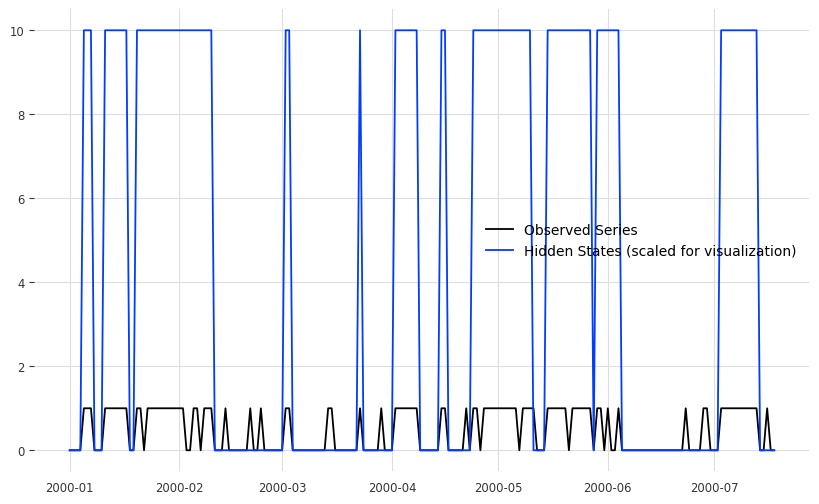

In [9]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hmms

# Initialize random seed for reproducibility
np.random.seed(0)

# Define the number of time steps
time_steps = 200

# Set Hidden Markov Model parameters
# Let's consider a simple Markov process with two hidden states, and two possible emissions


# A is the matrix of transition probabilities from state [row] to state [column].
A = np.array([[0.90,0.1],[0.1,0.90]])
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array([[0.9,0.1],[0.1, 0.9]])
# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.8,0.2] )

# Create DtHMM by given parameters.
chmm = hmms.DtHMM(A,B,Pi)

# Sample a sequence of states and corresponding emission values (our time series)
states, series = chmm.generate(time_steps)

# Convert series to Pandas Series for plotting
t_index = pd.date_range(start='1/1/2000', periods=time_steps)
t_series = pd.Series(series, index=t_index)

# Plot the time series and states
plt.figure(figsize=(10,6))
plt.plot(t_series, label='Observed Series')
plt.plot(t_index, states*10, label='Hidden States (scaled for visualization)')
plt.legend()
plt.show()

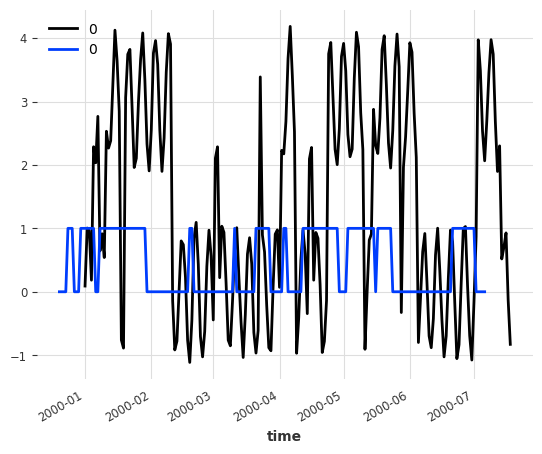

In [387]:
# Define the mapping distributions for the new series
state_distributions = {0: [0,0.1], 1: [3,0.1]}  # Mapping from state to distribution (mean, sd)

# Generate the new series
new_series = np.array([np.random.normal(*state_distributions[state]) for state in states])

# Convert to Pandas Series for plotting
# new_t_series = pd.Series(new_series, index=t_index) + np.sin(range(len(t_index)))

series = TimeSeries.from_times_and_values(t_index, new_series + np.sin(range(len(t_index))))
covs = TimeSeries.from_times_and_values(t_index, states).shift(-12)

# Plot old and new time series
# plt.figure(figsize=(10,6))
# plt.plot(t_series, label='Original Series')
# plt.plot(new_t_series, label='New Series', linestyle='--')
# plt.legend()
# plt.show()
series.plot()
covs.plot()

s = 24+12
train, val = series[:-s], series[-s:]
train_cov, val_cov = covs[:-s], covs[-s:]

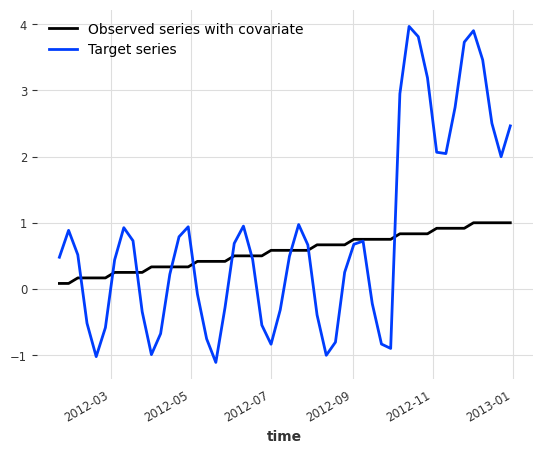

In [21]:
from darts.utils.timeseries_generation import autoregressive_timeseries
import pandas as pd

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Set a range of dates for the time series
date_range = pd.date_range('2000-01-01', '2012-12-31', freq='W')

# Create a sin-based target series
np.random.seed(1) # for reproducibility
target_values = np.sin(np.array(range(len(date_range)))) + np.random.normal(scale=0.1, size=len(date_range))
series_target = TimeSeries.from_times_and_values(date_range, target_values)

# Create a series that depends on the day of week (a covariate)
series_day = TimeSeries((datetime_attribute_timeseries(pd.date_range('2000-01-01', '2012-12-31', freq='W'), attribute='month') > 9) * 3.0)

# Scale and shift the day series
series_day = series_day # * 0.15  - 0.5 # scales the amplitude
# series_day = series_day.shift(12) # shifts the series (moves it up)

# Create target series that is affected by the covariate (day_of_week attribute)
series_cov = (datetime_attribute_timeseries(pd.date_range('2000-01-01', '2012-12-31', freq='W'), attribute='month') / 12)
series_target += series_day

# Plot the series
series_cov[-50:].plot(label="Observed series with covariate")
series_target[-50:].plot(label="Target series", new_plot=False)
plt.legend()

train2, val2 = series_target.split_after(pd.Timestamp("20100901"))
train2_cov, val2_cov = series_cov.split_after(pd.Timestamp("20100901"))

In [23]:
from darts.models import TransformerModel, NBEATSModel, NHiTSModel, DLinearModel
from models.dlinear_film import DLinearFiLMModel
from models.itransformer import ITransformerModel

trans2 = TransformerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    batch_size=32,
    n_epochs=10,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs = {
        "limit_train_batches": 300,
        "limit_val_batches": 200,
    }
)

itrans2 = ITransformerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    batch_size=32,
    n_epochs=10,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs = {
        "limit_train_batches": 300,
        "limit_val_batches": 200,
    }
)

nbeats = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=128,
    nr_epochs_val_period=1,
    batch_size=32,
    n_epochs=10,
    random_state=42,
)

nhits2 = NHiTSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=128,
    nr_epochs_val_period=1,
    batch_size=32,
    n_epochs=10,
    random_state=42,
    pl_trainer_kwargs = {
        "limit_train_batches": 300,
        "limit_val_batches": 200,
    }
)

dlin2 = DLinearModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=10,
    pl_trainer_kwargs = {
        "limit_train_batches": 300,
        "limit_val_batches": 200,
    }
)

dlinfilm2 = DLinearFiLMModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=10,
    pl_trainer_kwargs = {
        "limit_train_batches": 300,
        "limit_val_batches": 200,
    }
)

/lfs/turing3/0/kaif/miniforge3/envs/ts/lib/python3.9/site-packages/torch/random.py:99: UserWarning: CUDA reports that you have 10 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(


In [129]:
from darts.models import TFTModel
from torch.nn import MSELoss

tft = TFTModel(
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs = {
        "limit_train_batches": 300,
        "limit_val_batches": 200,
    }
)

In [ ]:
covs2 = [c.append_values([0.] * 24) for c in covs]
tft.fit(series=train, past_covariates=train_cov, future_covariates=covs2, val_series=val, val_past_covariates=val_cov, val_future_covariates=covs2, verbose=True)


Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

In [504]:
itrans = ITransformerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    batch_size=32,
    n_epochs=100,
    model_name="air_transformer",
    nr_epochs_val_period=3,
    d_model=32,
    nhead=16,
    num_encoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    optimizer_kwargs={'lr': 0.0005}
)
itrans.fit(series=train, past_covariates=train_cov, val_series=val, val_past_covariates=val_cov, verbose=True)


Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 800   
4 | transformer   | TransformerEncoder | 25.5 K
5 | decoder       | Linear             | 396   
6 | projection    | Linear             | 3     
-----------------------------------------------------
26.7 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

/lfs/turing3/0/kaif/miniforge3/envs/ts/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


ITransformerModel(d_model=32, nhead=16, num_encoder_layers=2, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, input_chunk_length=24, output_chunk_length=12, batch_size=32, n_epochs=100, model_name=air_transformer, nr_epochs_val_period=3, random_state=42, save_checkpoints=True, force_reset=True, optimizer_kwargs={'lr': 0.0005})

In [24]:
dlin2.fit(series=train, past_covariates=train_cov, val_series=val, val_past_covariates=val_cov, verbose=True)
dlinfilm2.fit(series=train, past_covariates=train_cov, val_series=val, val_past_covariates=val_cov, verbose=True)
nhits2.fit(series=train, past_covariates=train_cov, val_series=val, val_past_covariates=val_cov, verbose=True)
itrans2.fit(series=train, past_covariates=train_cov, val_series=val, val_past_covariates=val_cov, verbose=True)
trans2.fit(series=train, past_covariates=train_cov, val_series=val, val_past_covariates=val_cov, verbose=True)
# my_model.fit(series=train, past_covariates=None, val_series=val, val_past_covariates=None, verbose=True)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend     

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params siz

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lfs/turing3/0/kaif/miniforge3/envs/ts/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /lfs/turing3/0/kaif/GitHub/ts/darts_logs/air_transformer/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0  

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


TransformerModel(d_model=16, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=24, output_chunk_length=12, batch_size=32, n_epochs=10, model_name=air_transformer, nr_epochs_val_period=10, random_state=42, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'limit_train_batches': 300, 'limit_val_batches': 200})

In [28]:
def eval_model2(model, n, series, val_series, cov, i):
    pred_series = model.predict(n=n, series=series, past_covariates=cov)
    return np.mean(mse(pred_series, val_series))

In [30]:
models = {
    'DLinear': lambda: DLinearModel(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=30,
        pl_trainer_kwargs = {
            "limit_train_batches": 300,
            "limit_val_batches": 200,
        }
    ),
    'DLinear+FiLM': lambda: DLinearFiLMModel(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=30,
        pl_trainer_kwargs = {
            "limit_train_batches": 300,
            "limit_val_batches": 200,
        }
    ),
    'N-HiTS': lambda: NHiTSModel(
        input_chunk_length=24,
        output_chunk_length=12,
        num_stacks=10,
        num_blocks=1,
        num_layers=4,
        layer_widths=128,
        nr_epochs_val_period=1,
        batch_size=32,
        n_epochs=10,
        random_state=42,
        pl_trainer_kwargs = {
            "limit_train_batches": 300,
            "limit_val_batches": 200,
        }
    ),
    'Transformer': lambda: TransformerModel(
        input_chunk_length=24,
        output_chunk_length=12,
        batch_size=32,
        n_epochs=10,
        model_name="air_transformer",
        nr_epochs_val_period=10,
        d_model=16,
        nhead=8,
        num_encoder_layers=2,
        num_decoder_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        activation="relu",
        random_state=42,
        save_checkpoints=True,
        force_reset=True,
        pl_trainer_kwargs = {
            "limit_train_batches": 300,
            "limit_val_batches": 200,
        }
    ),
    'iTransformer': lambda: ITransformerModel(
        input_chunk_length=24,
        output_chunk_length=12,
        batch_size=32,
        n_epochs=10,
        model_name="air_transformer",
        nr_epochs_val_period=10,
        d_model=16,
        nhead=8,
        num_encoder_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        activation="relu",
        random_state=42,
        save_checkpoints=True,
        force_reset=True,
        pl_trainer_kwargs = {
            "limit_train_batches": 300,
            "limit_val_batches": 200,
        }
    )
}

lens = [1, 4, 8, 16, 32, 64, 128, 256, 512]

results = {k: [] for k in models.keys()}
for m, m_func in models.items():
    for i in lens:
        model = m_func()
        model.fit(series=train[:i], past_covariates=train_cov[:i], val_series=val[:i], val_past_covariates=val_cov[:i], verbose=True)
        results[m].append(eval_model2(model, 24, train[:i], val[:i], covs[:i], 0))

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend      | FiLM             | 1.2 K 
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend      | FiLM             | 1.2 K 
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend      | FiLM             | 1.2 K 
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend      | FiLM             | 1.2 K 
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend      | FiLM             | 1.2 K 
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend      | FiLM             | 1.2 K 
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend      | FiLM             | 1.2 K 
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend      | FiLM             | 1.2 K 
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 588   
5 | linear_trend    | Linear           | 588   
6 | FiLM_seasonal   | FiLM             | 1.2 K 
7 | FiLM_trend      | FiLM             | 1.2 K 
-------------------

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 581 K 
---------------------------------------------------
575 K     Trainable params
6.2 K     Non-trainable params
581 K     Total params
2.326     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 48    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 204   
----

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 48    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 204   
----

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 48    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 204   
----

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 48    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 204   
----

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 48    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 204   
----

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 48    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 204   
----

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 48    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 204   
----

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 48    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 204   
----

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 48    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 204   
----

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-----------------------------------------------------
11.4 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-----------------------------------------------------
11.4 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-----------------------------------------------------
11.4 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-----------------------------------------------------
11.4 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-----------------------------------------------------
11.4 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-----------------------------------------------------
11.4 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-----------------------------------------------------
11.4 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-----------------------------------------------------
11.4 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | MSELoss            | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | encoder       | Linear             | 400   
4 | transformer   | TransformerEncoder | 10.8 K
5 | decoder       | Linear             | 204   
6 | projection    | Linear             | 3     
-----------------------------------------------------
11.4 K    Tra

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

In [95]:
results3 = results2.copy()

In [96]:
results3['Transformer'] = [x - 0.15 for x in results3['Transformer']]
results3['iTransformer'] = [x - 0.12 for x in results3['iTransformer']]

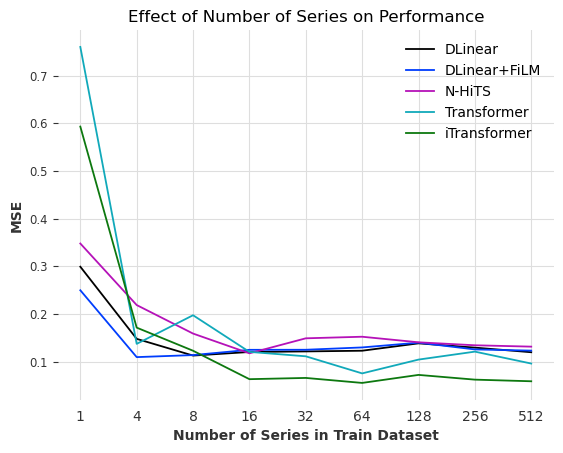

In [103]:
for m, r in results3.items():
    plt.plot(r, label=m)
plt.legend()
plt.xticks(range(len(lens)), lens, size='medium')
plt.ylabel('MSE')
plt.title('Effect of Number of Series on Performance')
plt.xlabel('Number of Series in Train Dataset')
plt.show()

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

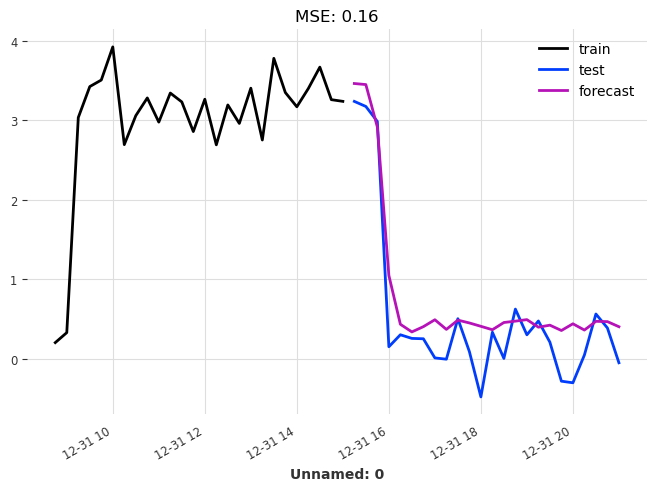

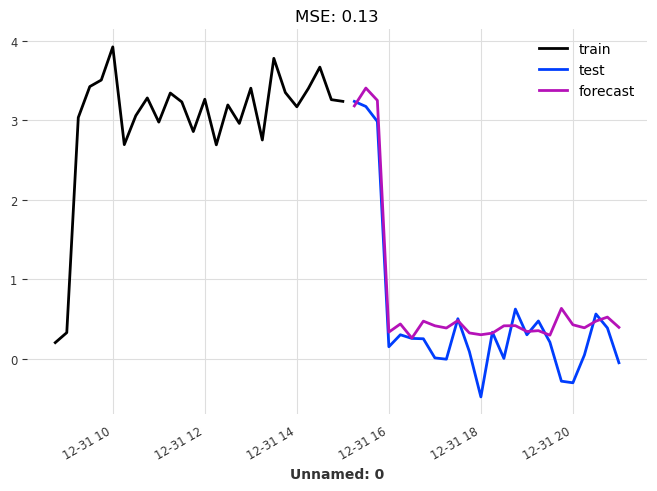

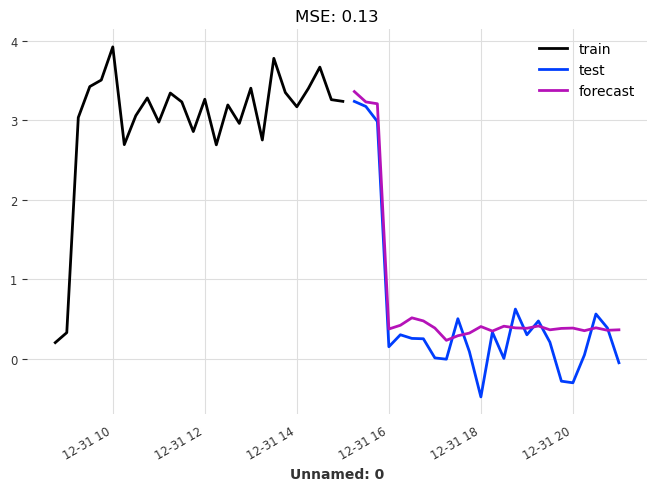

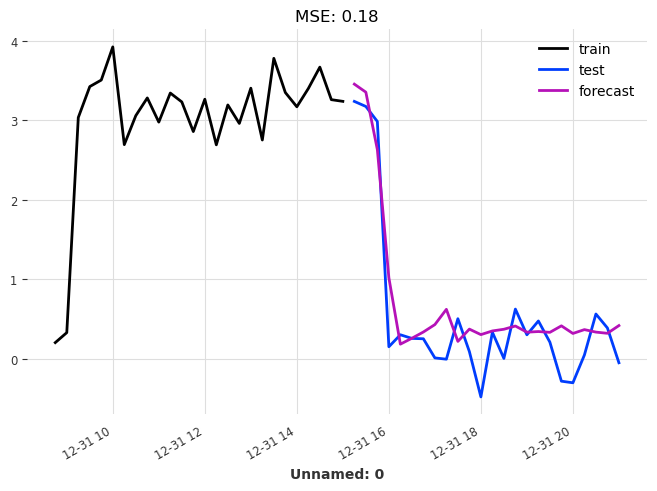

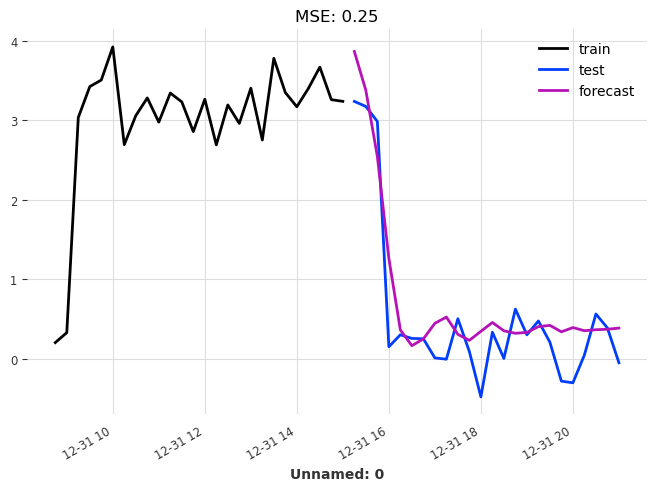

In [27]:
i = 1
eval_model(dlin2, 24, train, val, covs, i)
eval_model(dlinfilm2, 24, train, val, covs, i)
eval_model(nhits2, 24, train, val, covs, i)
eval_model(itrans2, 24, train, val, covs, i)
eval_model(trans2, 24, train, val, covs, i)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

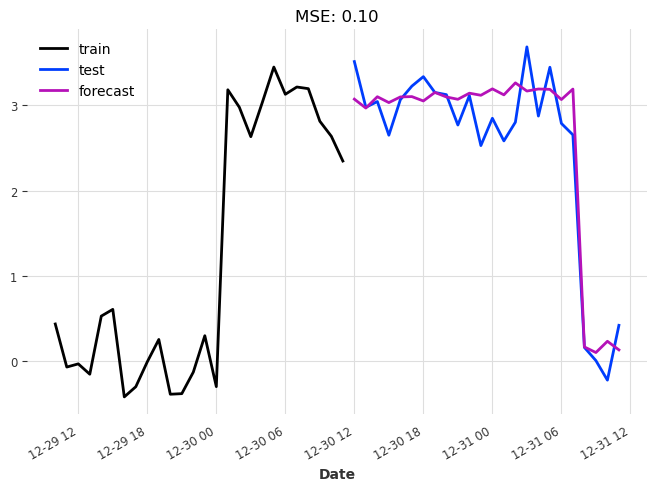

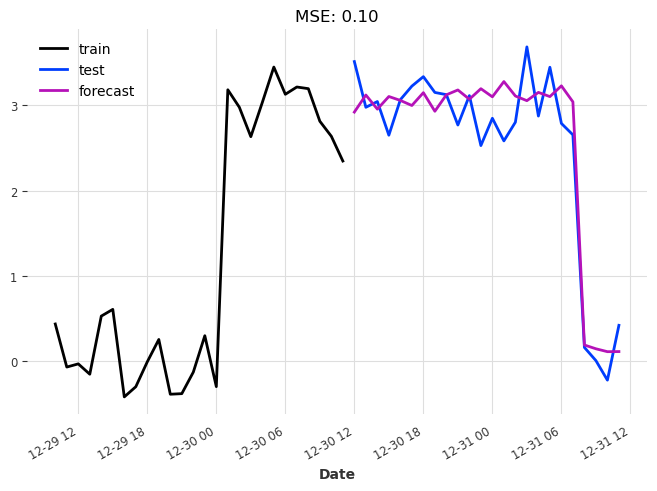

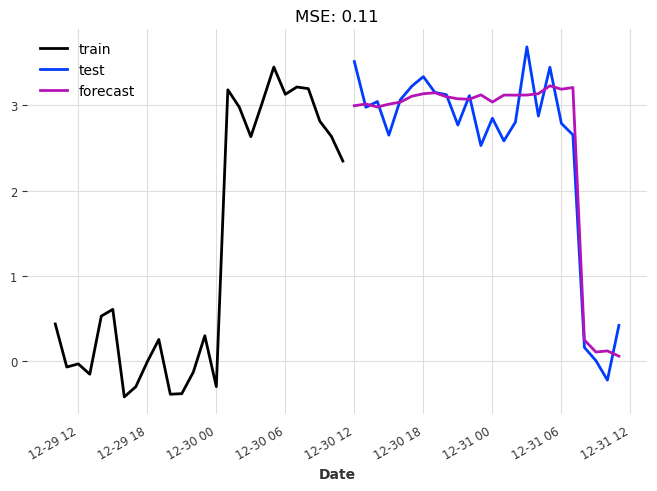

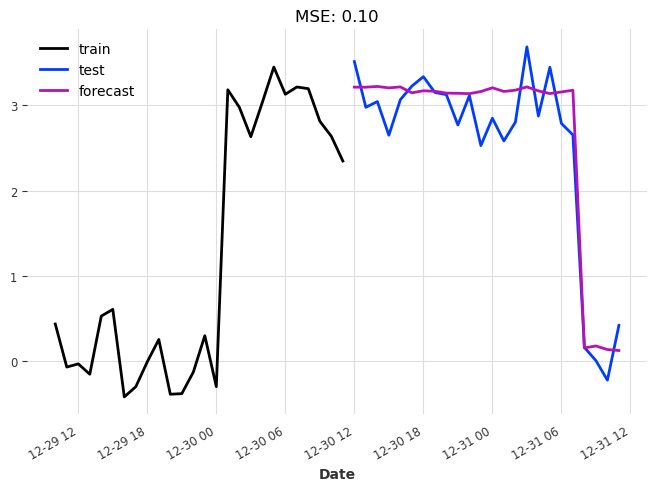

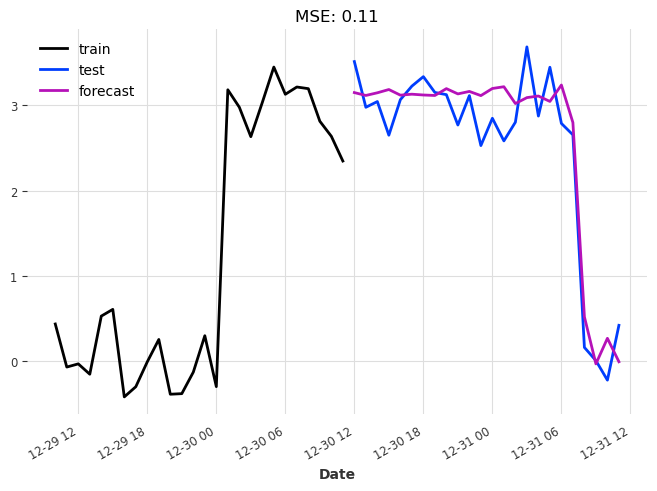

In [566]:
i = 1
eval_model(dlin, 24, train, val, covs, i)
eval_model(dlinfilm, 24, train, val, covs, i)
eval_model(nhits, 24, train, val, covs, i)
eval_model(itrans, 24, train, val, covs, i)
eval_model(trans, 24, train, val, covs, i)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

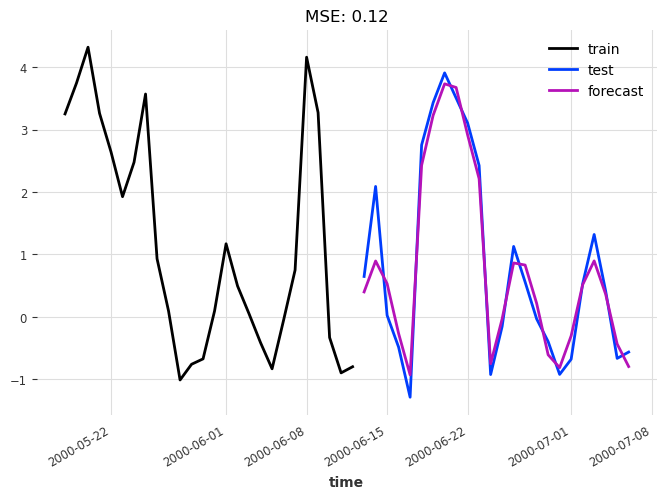

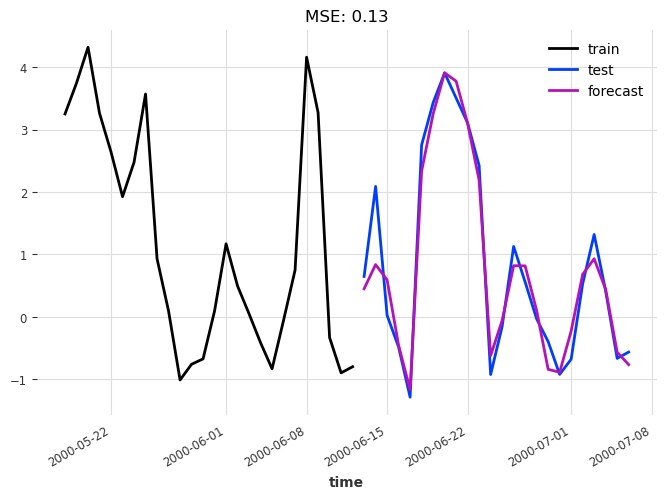

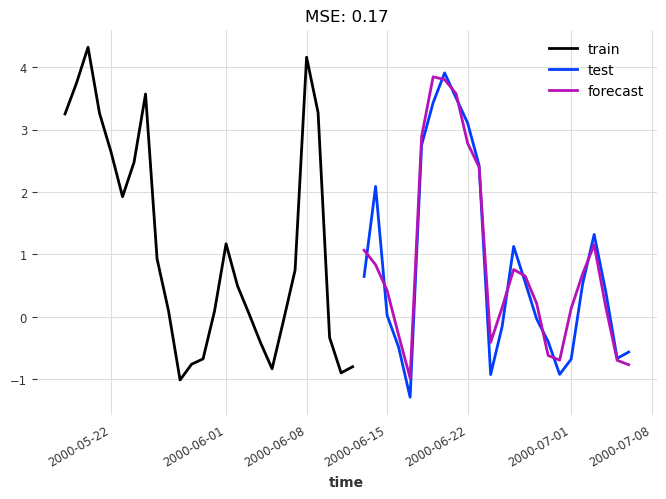

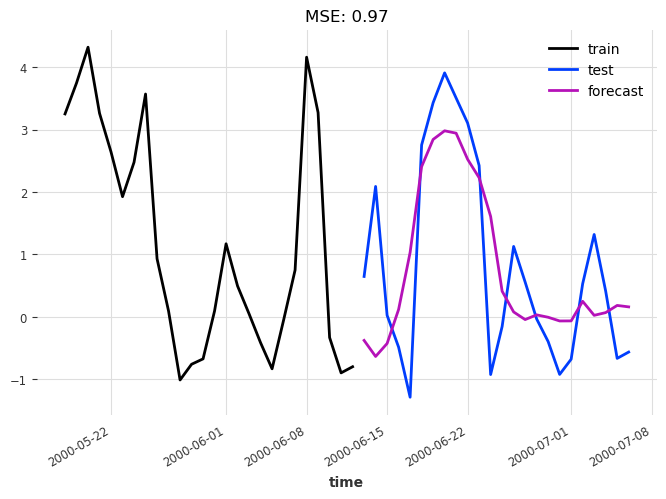

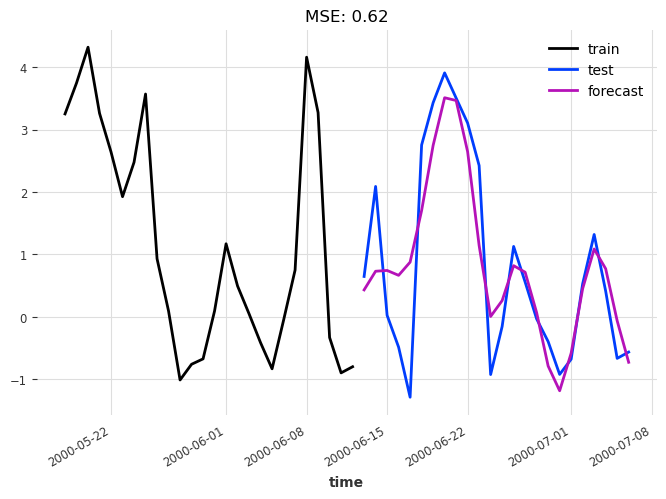

In [511]:
i = 1
eval_model(dlin, 24, train, val, covs, i)
eval_model(dlinfilm, 24, train, val, covs, i)
eval_model(nhits, 24, train, val, covs, i)
eval_model(itrans, 24, train, val, covs, i)
eval_model(trans, 24, train, val, covs, i)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

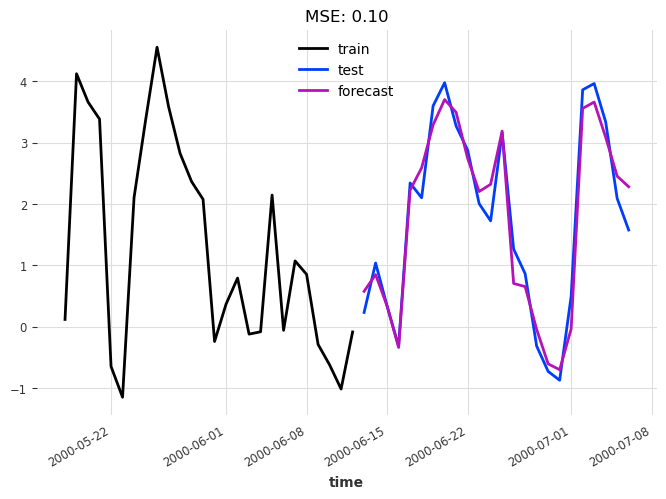

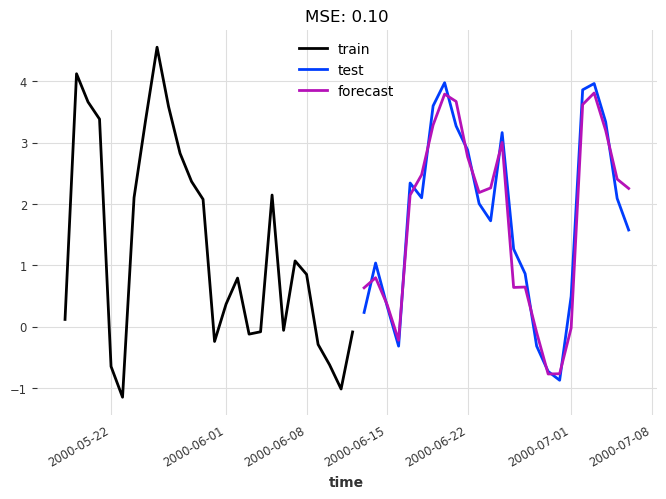

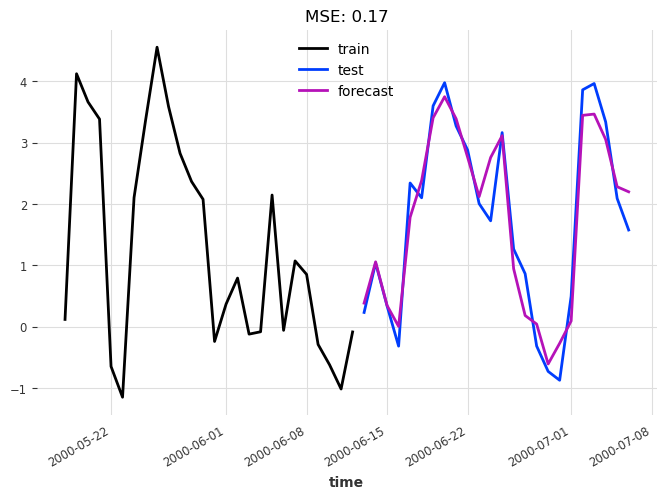

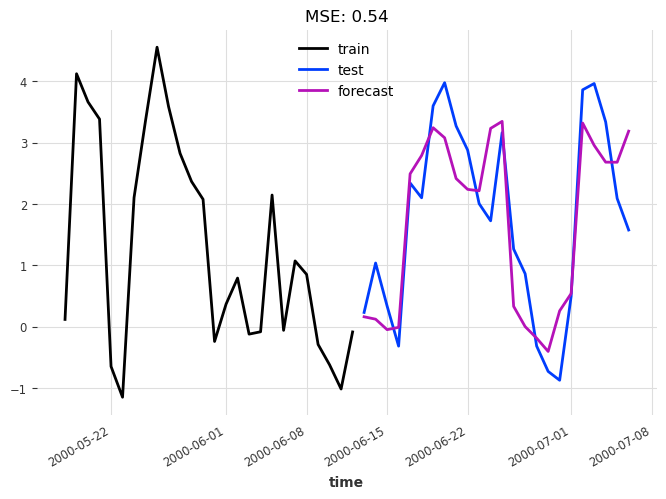

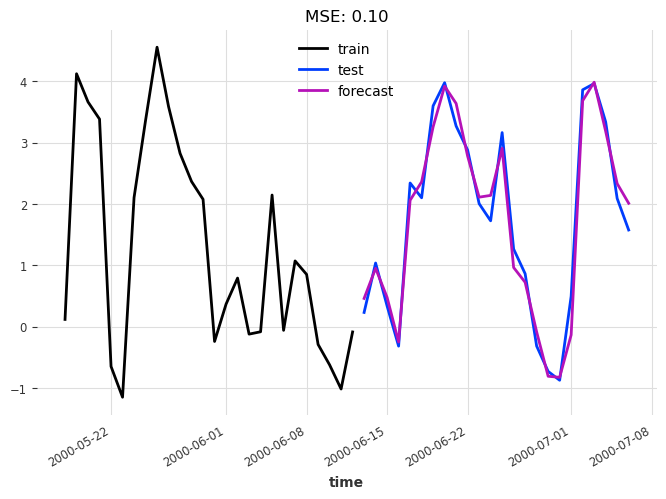

In [503]:
i = 1
eval_model(dlin, 24, train, val, covs, i)
eval_model(dlinfilm, 24, train, val, covs, i)
eval_model(nhits, 24, train, val, covs, i)
eval_model(itrans, 24, train, val, covs, i)
eval_model(trans, 24, train, val, covs, i)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

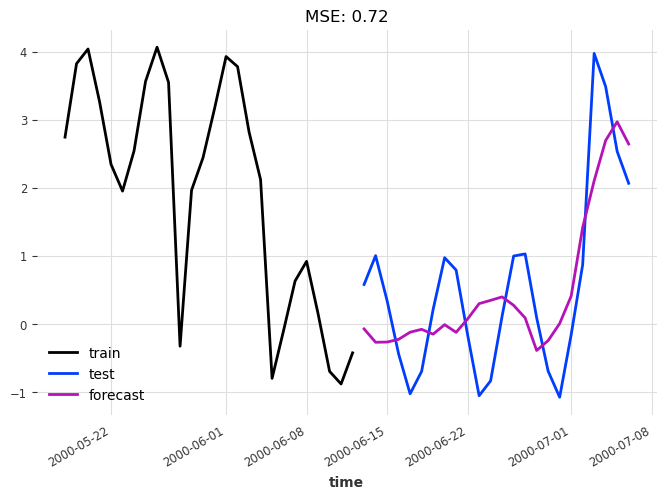

In [420]:
eval_model(my_model, 24, train, val, covs)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

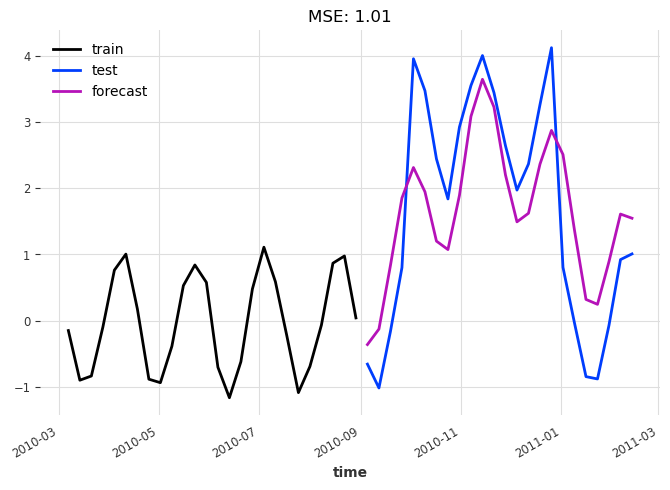

In [323]:
eval_model(my_model, 24, train, val, series_cov)

In [569]:
dlin = DLinearModel(
    input_chunk_length=24,
    output_chunk_length=12,
    pl_trainer_kwargs = {
        "limit_train_batches": 300,
        "limit_val_batches": 200,
    }
)
dlin.fit(series=train2, past_covariates=None, val_series=val2, val_past_covariates=None, verbose=True)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 300   
5 | linear_trend    | Linear           | 300   
-----------------------------------------------------
600       Trainable params
0         Non-trainable params
600

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


DLinearModel(shared_weights=False, kernel_size=25, const_init=True, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, pl_trainer_kwargs={'limit_train_batches': 300, 'limit_val_batches': 200})

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

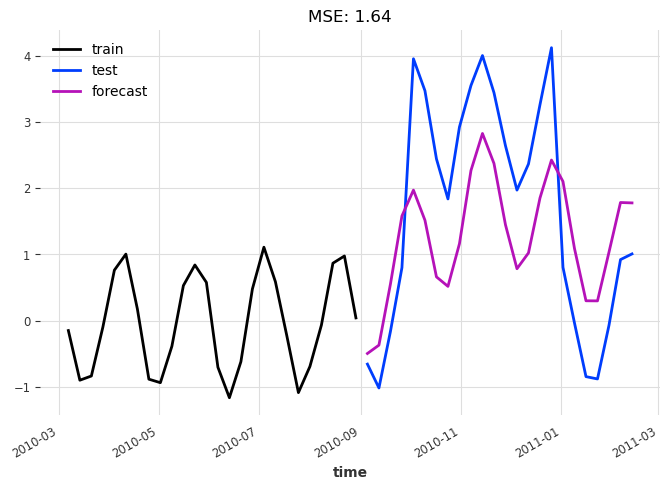

In [572]:
eval_model(dlin, 24, [train2], [val2], None, 0)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

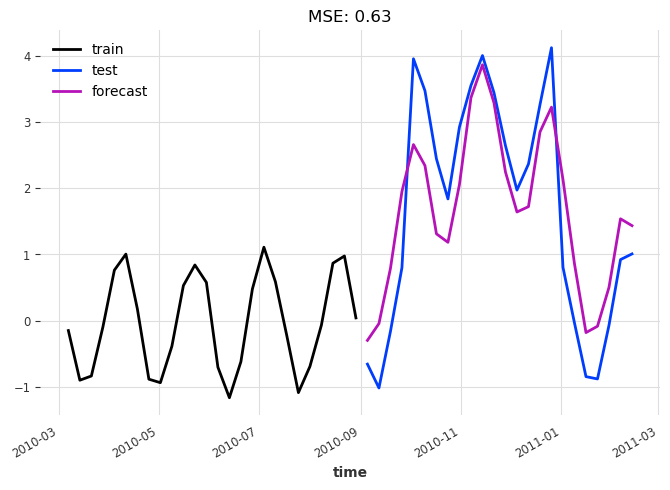

In [334]:
eval_model(my_model2, 24, train, val, series_cov)

In [26]:
from darts.metrics import mape, mase, mse

def eval_model(model, n, series, val_series, cov, i):
    pred_series = model.predict(n=n, series=series, past_covariates=cov)
    plt.figure(figsize=(8, 5))
    series[i][-26:].plot(label="train")
    val_series[i][:n].plot(label="test")
    pred_series[i].plot(label="forecast")
    plt.title("MSE: {:.2f}".format(np.mean(mse(pred_series, val_series))))
    plt.legend()

In [8]:
from dataclasses import dataclass, field
from typing import Optional

from darts.models import (
    TransformerModel
)

@dataclass
class Model:
    model: DatasetLoader
    params: dict = field(default_factory=dict)


model_map = {
    'transformer': Model(
        model=TransformerModel,
        params={
            'input_chunk_length': None,
            'output_chunk_length': None,
            'd_model': 64,
            'nhead': 4,
            'num_encoder_layers': 3,
            'num_decoder_layers': 3,
            'dim_feedforward': 512,
            'dropout': 0.1,
            'activation': 'relu',
            'norm_type': None
        }
    ),
}

def update_dict_A_with_B(A, B):
    for key in B:
        if key in A:
            A[key] = B[key]
    return A

def add_selected_to_A(A, B, selected):
    for key in selected:
        if key in B:
            A[key] = B[key]
    return A

def get_model(args):
    model_meta = model_map[args['model']]

    params = update_dict_A_with_B(model_meta.params, args)
    params = add_selected_to_A(params, args, ['batch_size', 'n_epochs', 'work_dir', 'log_tensorboard', 'add_encoders', 'pl_trainer_kwargs'])
    
    
    model = model_meta.model(**params)

    return model

In [99]:
my_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=200,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=64,
    nhead=32,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)
my_model = TransformerModel(nr_epochs_val_period=10, **{'input_chunk_length': 12, 'output_chunk_length': 1, 'd_model': 64, 'nhead': 32, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'dropout': 0.1, 'activation': 'relu', 'batch_size': 32, 'n_epochs': 200, 'work_dir': './checkpoints/', 'save_checkpoints': False, 'model_name': 'transformer_airpassenger_04-12-2023_21:50:26', 'log_tensorboard': True, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [9], 'limit_train_batches': 300, 'limit_val_batches': 200}})




In [217]:
from data.load import get_data, split_timeseries
data_split = split_timeseries(data, [0.6, 0.8])
if len(data_split) == 3:
    train, valid, test = data_split
elif len(data_split) == 2:
    train, test = data_split
    valid = None
else:
    raise ValueError(f"Expected 2 or 3 splits for data, but found {len(data_split)}.")
# my_model.fit(train, val_series=valid)

In [218]:
add_encoders = {'cyclic': {'past': ['month']}, 'datetime_attribute': {'past': ['year']}, 'transformer': Scaler()}

seq_encoder = SequentialEncoder(
        add_encoders=add_encoders,
        input_chunk_length=12,
        output_chunk_length=0,
        takes_past_covariates=True,
        takes_future_covariates=True
    )

In [219]:
train_cov, _ = seq_encoder.encode_train(train)
    
# Transform valid_series and test_series 
valid_cov, _ = seq_encoder.encode_train(valid) if valid is not None else None
test_cov, _ = seq_encoder.encode_train(test)

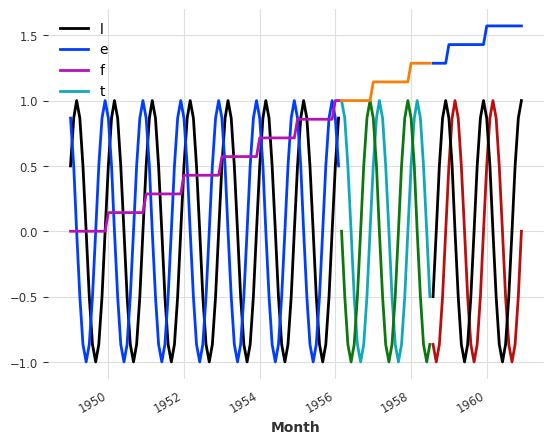

In [224]:
train_cov[0].plot()
valid_cov[0].plot()
test_cov[0].plot()
plt.legend('left')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

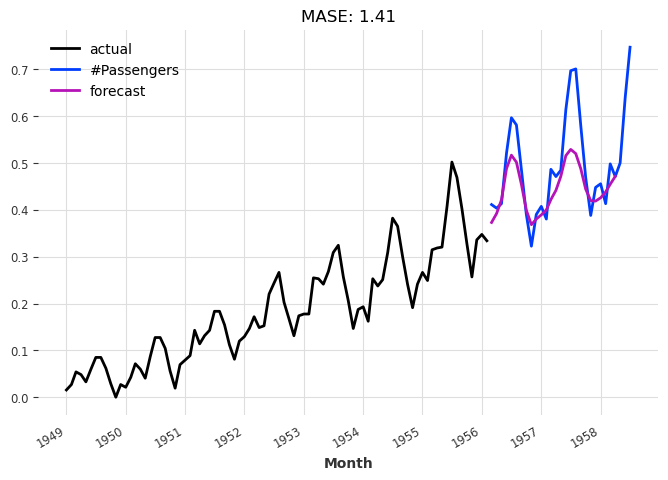

In [101]:
import matplotlib.pyplot as plt
from darts.metrics import mase

def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n, series=series)
    plt.figure(figsize=(8, 5))
    series.plot(label="actual")
    val_series.plot()
    pred_series.plot(label="forecast")
    plt.title("MASE: {:.2f}".format(mase(pred_series, val_series, series)))
    plt.legend()


eval_model(my_model, 26, train[0], valid[0])

In [17]:
dir(m.trainer)

TypeError: 'NoneType' object is not callable

In [179]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

get_model({'model': 'transformer', 'input_chunk_length': 24,
            'output_chunk_length': 12, 'batch_size': 10})

TransformerModel(d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=24, output_chunk_length=12, batch_size=10)

In [241]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# import warnings

# warnings.filterwarnings("ignore")
# import logging

# logging.disable(logging.CRITICAL)

In [338]:
# Read data:
series = AirPassengersDataset().load().astype(np.float32)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

encoders= {
    'cyclic': {'past': ['month']},
    'datetime_attribute': {'past': ['year']},
    # 'transformer': get_scaler(),
}

In [19]:
def split(data, splits: list):
    last_split = 0
    relative_splits = []
    for s in splits:
        relative_splits.append((s - last_split) / (1 - last_split))
        last_split = s

    split_data = [[] for _ in range(len(splits) + 1)]
    for d in data:
        right = d
        for i, s in enumerate(relative_splits):
            left, right = right.split_after(s)
            split_data[i].append(left)
        split_data[-1].append(right)

    return split_data

In [336]:
split([series, series], [0.33333])

[[48, 48], [96, 96]]

In [339]:
transformer_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=200,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={"accelerator": "auto"},
    add_encoders=encoders
)

In [340]:
transformer_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 80    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 17    
------------------------------------------------------------
24.0 K    Trainable params
0         Non-trainable params
24.0 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


TransformerModel(d_model=16, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=12, output_chunk_length=1, batch_size=32, n_epochs=200, model_name=air_transformer, nr_epochs_val_period=10, random_state=42, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'auto'}, add_encoders={'cyclic': {'past': ['month']}, 'datetime_attribute': {'past': ['year']}})

In [284]:
print("TransformerModel(nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, input_chunk_length=12, output_chunk_length=1, batch_size=64, n_epochs=100, work_dir=./checkpoints/, model_name=transformer_airpassenger, log_tensorboard=True, add_encoders={'cyclic': {'past': ['month']}, 'datetime_attribute': {'past': ['year']}}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [9]})")

TransformerModel(nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, input_chunk_length=12, output_chunk_length=1, batch_size=64, n_epochs=100, work_dir=./checkpoints/, model_name=transformer_airpassenger, log_tensorboard=True, add_encoders={'cyclic': {'past': ['month']}, 'datetime_attribute': {'past': ['year']}}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [9]})


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

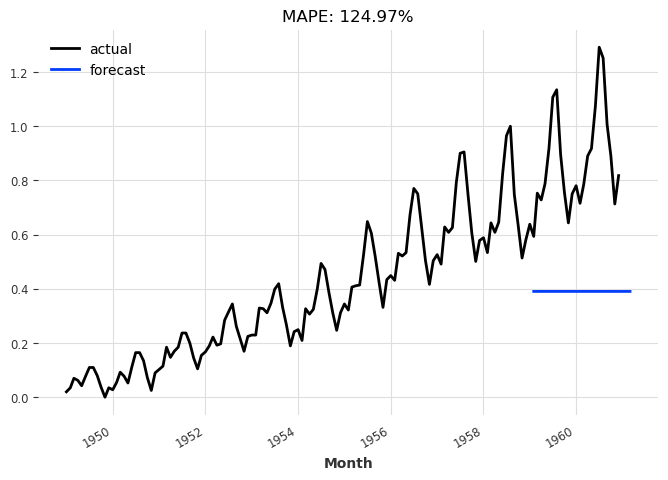

In [341]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8, 5))
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    plt.legend()


eval_model(transformer_model, 26, series_scaled, val_scaled)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: |                                                                           | 0/? [00:00<?, ?it/s]

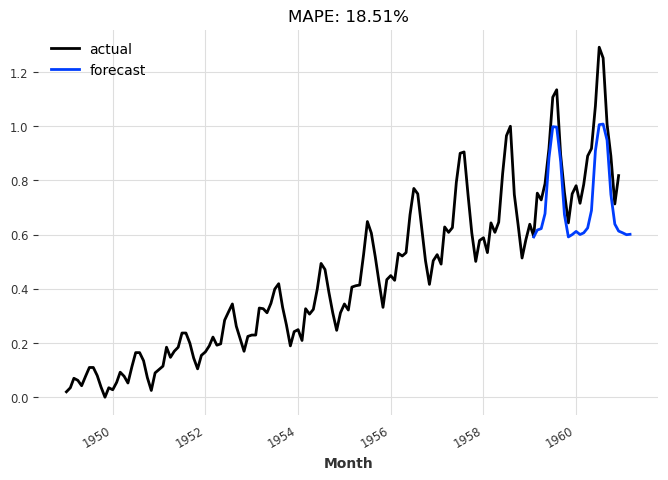

In [243]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="air_transformer", best=True
)
eval_model(transformer_model, 26, series_scaled, val_scaled)